#### Please note that if you rerun this code, it will produce different results as the craigslist listings are constantly being updated, removed and added (in addition to taking many hours to run). This notebook scraped two sets of urls close to a week apart.

# scraping craigslist

We'll first look at listing data from Craigslist and attempt to store as many listings as possible. The end product of this notebook will be a single DataFrame that consists of listing urls, descriptions, rent prices, # of BD/BA, and total square feet. 

In [ ]:
##run this first to install package
pip install webdriver-manager selenium pandas

Import necessary libraries for scraping, parsing text, plotting, etc.

In [195]:
# import libraries
import time 
import json
import random
import requests
import pandas as pd 
import numpy as np
from selenium import webdriver 
from selenium.webdriver import Chrome 
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.common.by import By 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import WebDriverWait
import time
pd.options.mode.chained_assignment = None

Initiate webdriver

In [200]:
# start by defining the options 
options = webdriver.ChromeOptions() 
options.headless = True # it's more scalable to work in headless mode 
# normally, selenium waits for all resources to download 
# we don't need it as the page also populated with the running javascript code. 
options.page_load_strategy = 'none' 
# this returns the path web driver downloaded 
chrome_path = ChromeDriverManager().install() 
chrome_service = Service(chrome_path) 
# pass the defined options and service objects to initialize the web driver 
driver = Chrome(options=options, service=chrome_service) 
driver.implicitly_wait(5)

/var/folders/c2/k5ncd_gj29q_qdsk52wqdd500000gn/T/ipykernel_81753/210964506.py:3: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True # it's more scalable to work in headless mode


This stores a list of listing urls based on a desired quantity (each listing page contains 120 listings).

In [201]:
url_list = []
page = 0
num_pages = 77

# get urls
for x in range(num_pages):
    page += 1 
    url_list.append("https://losangeles.craigslist.org/search/apa?query=los%20angeles#search=1~list~{}~0".format(page))

### Obtain Listing URLs  

For each page of listings, we need to grab the urls for each of the 120 individual listings.

In [ ]:
listings = []

for url in url_list:
    # create WebElement of Listings Page
    driver.get(url)
    
    #driver.implicitly_wait(5)
    
    # find the section the listings are located in
    content = driver.find_element(By.CSS_SELECTOR, "div[class*='cl-results-page'")
    
    # find the section where the link to the property page is located for each 120 listings
    for element in content.find_elements(By.TAG_NAME, "li")[1:]:
        try:
            listings.append(element.find_elements(By.CSS_SELECTOR, "div[class*='result-node-wide']>a")[0].get_attribute("href"))
            
        except (StaleElementReferenceException, NoSuchElementException) as e:
            listings.append('NA')
    
            
    # add delay (not sure about actually length of time delays necessary)
    # time.sleep(random.uniform(.5, 1.5))
    
listingsDf = pd.DataFrame(listings)
listingsDf.rename(columns = {0:"urls"}, inplace = True)

# check DF
listingsDf.head()

In [ ]:
listingsDf[listingsDf.urls == 'NA']

In [ ]:
print(listingsDf.shape)
listingsDf = listingsDf[listingsDf.urls != 'NA']
print(listingsDf.shape)

### Scrape Subsetted Dataframes

Now we will scrape each webpage from the list of urls, however, issues have arrived when attempting to run requests on all urls within one code block. When executing all at one, only 30% of the webpages are successfully scraped. The only resolution that we could find within our limited timeframe was to subet the dataframe into smaller, equal dataframes. With this method, we are able to successfully capture >85% of the listing urls. 

In [69]:
listingsDf_1 = listingsDf[0:1000]
listingsDf_2 = listingsDf[1001:2000] 
listingsDf_3 = listingsDf[2001:3000] 
listingsDf_4 = listingsDf[3001:4000]  
listingsDf_5 = listingsDf[4001:5000]
listingsDf_6 = listingsDf[5001:6000]  
listingsDf_7 = listingsDf[6001:7000]
listingsDf_8 = listingsDf[7001:8000]
listingsDf_9 = listingsDf[8001:8995]

#### Listing DF #1 

In [74]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_1['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_1)]
latitude = latitude[:len(listingsDf_1)]
longitude = longitude[:len(listingsDf_1)]
prices = prices[:len(listingsDf_1)]
attributes = attributes[:len(listingsDf_1)]
    
# create new columns
listingsDf_1['attributes'] = attributes
listingsDf_1['price'] = prices
listingsDf_1['description'] = description
listingsDf_1['lat'] = latitude
listingsDf_1['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2724.3719980716705 seconds


In [100]:
listingsDf_1[(listingsDf_1['price'] == 'NA') |
             (listingsDf_1['description'] == 'NA') | 
             (listingsDf_1['attributes'] == 'NA') | 
             (listingsDf_1['lat'] == 'NA') |
             (listingsDf_1['lat'] == 'NA')].shape

(178, 6)

#### Listing DF #2 

In [104]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_2['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_2)]
latitude = latitude[:len(listingsDf_2)]
longitude = longitude[:len(listingsDf_2)]
prices = prices[:len(listingsDf_2)]
attributes = attributes[:len(listingsDf_2)]
    
# create new columns
listingsDf_2['attributes'] = attributes
listingsDf_2['price'] = prices
listingsDf_2['description'] = description
listingsDf_2['lat'] = latitude
listingsDf_2['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2274.9305188655853 seconds


In [106]:
listingsDf_2[(listingsDf_2['price'] == 'NA') |
             (listingsDf_2['description'] == 'NA') | 
             (listingsDf_2['attributes'] == 'NA') | 
             (listingsDf_2['lat'] == 'NA') |
             (listingsDf_2['lat'] == 'NA')].shape

(98, 6)

#### Listing DF #3

In [107]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_3['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_3)]
latitude = latitude[:len(listingsDf_3)]
longitude = longitude[:len(listingsDf_3)]
prices = prices[:len(listingsDf_3)]
attributes = attributes[:len(listingsDf_3)]
    
# create new columns
listingsDf_3['attributes'] = attributes
listingsDf_3['price'] = prices
listingsDf_3['description'] = description
listingsDf_3['lat'] = latitude
listingsDf_3['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2794.134661912918 seconds


In [108]:
listingsDf_3[(listingsDf_3['price'] == 'NA') |
             (listingsDf_3['description'] == 'NA') | 
             (listingsDf_3['attributes'] == 'NA') | 
             (listingsDf_3['lat'] == 'NA') |
             (listingsDf_3['lat'] == 'NA')].shape

(202, 6)

#### Listing DF #4

In [109]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_4['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_4)]
latitude = latitude[:len(listingsDf_4)]
longitude = longitude[:len(listingsDf_4)]
prices = prices[:len(listingsDf_4)]
attributes = attributes[:len(listingsDf_4)]
    
# create new columns
listingsDf_4['attributes'] = attributes
listingsDf_4['price'] = prices
listingsDf_4['description'] = description
listingsDf_4['lat'] = latitude
listingsDf_4['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2178.817973136902 seconds


In [110]:
listingsDf_4[(listingsDf_4['price'] == 'NA') |
             (listingsDf_4['description'] == 'NA') | 
             (listingsDf_4['attributes'] == 'NA') | 
             (listingsDf_4['lat'] == 'NA') |
             (listingsDf_4['lat'] == 'NA')].shape

(101, 6)

#### Listing DF $5

In [111]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_5['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_5)]
latitude = latitude[:len(listingsDf_5)]
longitude = longitude[:len(listingsDf_5)]
prices = prices[:len(listingsDf_5)]
attributes = attributes[:len(listingsDf_5)]
    
# create new columns
listingsDf_5['attributes'] = attributes
listingsDf_5['price'] = prices
listingsDf_5['description'] = description
listingsDf_5['lat'] = latitude
listingsDf_5['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2046.824210882187 seconds


In [112]:
listingsDf_5[(listingsDf_5['price'] == 'NA') |
             (listingsDf_5['description'] == 'NA') | 
             (listingsDf_5['attributes'] == 'NA') | 
             (listingsDf_5['lat'] == 'NA') |
             (listingsDf_5['lat'] == 'NA')].shape

(79, 6)

#### Listing DF #6

In [113]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_6['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_6)]
latitude = latitude[:len(listingsDf_6)]
longitude = longitude[:len(listingsDf_6)]
prices = prices[:len(listingsDf_6)]
attributes = attributes[:len(listingsDf_6)]
    
# create new columns
listingsDf_6['attributes'] = attributes
listingsDf_6['price'] = prices
listingsDf_6['description'] = description
listingsDf_6['lat'] = latitude
listingsDf_6['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 3890.883061170578 seconds


In [114]:
listingsDf_6[(listingsDf_6['price'] == 'NA') |
             (listingsDf_6['description'] == 'NA') | 
             (listingsDf_6['attributes'] == 'NA') | 
             (listingsDf_6['lat'] == 'NA') |
             (listingsDf_6['lat'] == 'NA')].shape

(259, 6)

#### Listing DF #7

In [115]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_7['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_7)]
latitude = latitude[:len(listingsDf_7)]
longitude = longitude[:len(listingsDf_7)]
prices = prices[:len(listingsDf_7)]
attributes = attributes[:len(listingsDf_7)]
    
# create new columns
listingsDf_7['attributes'] = attributes
listingsDf_7['price'] = prices
listingsDf_7['description'] = description
listingsDf_7['lat'] = latitude
listingsDf_7['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 3464.2105798721313 seconds


In [116]:
listingsDf_7[(listingsDf_7['price'] == 'NA') |
             (listingsDf_7['description'] == 'NA') | 
             (listingsDf_7['attributes'] == 'NA') | 
             (listingsDf_7['lat'] == 'NA') |
             (listingsDf_7['lat'] == 'NA')].shape

(236, 6)

#### Listing DF #8

In [117]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_8['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_8)]
latitude = latitude[:len(listingsDf_8)]
longitude = longitude[:len(listingsDf_8)]
prices = prices[:len(listingsDf_8)]
attributes = attributes[:len(listingsDf_8)]
    
# create new columns
listingsDf_8['attributes'] = attributes
listingsDf_8['price'] = prices
listingsDf_8['description'] = description
listingsDf_8['lat'] = latitude
listingsDf_8['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2600.710641860962 seconds


In [118]:
listingsDf_8[(listingsDf_8['price'] == 'NA') |
             (listingsDf_8['description'] == 'NA') | 
             (listingsDf_8['attributes'] == 'NA') | 
             (listingsDf_8['lat'] == 'NA') |
             (listingsDf_8['lat'] == 'NA')].shape

(130, 6)

#### Listing DF #9

In [98]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_9['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_9)]
latitude = latitude[:len(listingsDf_9)]
longitude = longitude[:len(listingsDf_9)]
prices = prices[:len(listingsDf_9)]
attributes = attributes[:len(listingsDf_9)]
    
# create new columns
listingsDf_9['attributes'] = attributes
listingsDf_9['price'] = prices
listingsDf_9['description'] = description
listingsDf_9['lat'] = latitude
listingsDf_9['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 1603.15673995018 seconds


In [119]:
listingsDf_9[(listingsDf_9['price'] == 'NA') |
             (listingsDf_9['description'] == 'NA') | 
             (listingsDf_9['attributes'] == 'NA') | 
             (listingsDf_9['lat'] == 'NA') |
             (listingsDf_9['lat'] == 'NA')].shape

(48, 6)

The original listing urls were scraped days prior to final output and for this reason, we will scrape the listing host pages again to see if any more listings have been added since our original code execution as it will help us gain more observations. We'll remove any urls that overlap with our original dataframe to avoid duplicate work.

### Obtain Listing URLs - Round 2

In [203]:
listings_2nd = []

for url in url_list:
    # create WebElement of Listings Page
    driver.get(url)
    
    #driver.implicitly_wait(5)
    
    # find the section the listings are located in
    content = driver.find_element(By.CSS_SELECTOR, "div[class*='cl-results-page'")
    
    # find the section where the link to the property page is located for each 120 listings
    for element in content.find_elements(By.TAG_NAME, "li")[1:]:
        try:
            listings_2nd.append(element.find_elements(By.CSS_SELECTOR, "div[class*='result-node-wide']>a")[0].get_attribute("href"))
            
        except (StaleElementReferenceException, NoSuchElementException) as e:
            listings_2nd.append('NA')
    
            
    # add delay (not sure about actually length of time delays necessary)
    # time.sleep(random.uniform(.5, 1.5))
    
listingsDf_2nd = pd.DataFrame(listings_2nd)
listingsDf_2nd.rename(columns = {0:"urls"}, inplace = True)

# check DF
listingsDf_2nd.head()

urls
0  https://losangeles.craigslist.org/lac/apa/d/lo...
1  https://losangeles.craigslist.org/lac/apa/d/lo...
2  https://losangeles.craigslist.org/lac/apa/d/lo...
3  https://losangeles.craigslist.org/wst/apa/d/lo...
4  https://losangeles.craigslist.org/wst/apa/d/lo...

In [204]:
print(listingsDf_2nd.shape)
listingsDf_2nd = listingsDf_2nd[listingsDf_2nd.urls != 'NA']
print(listingsDf_2nd.shape)

(9119, 1)
(9116, 1)


In [205]:
# remove overlap
listingsDf_2nd = listingsDf_2nd[~listingsDf_2nd['urls'].isin(listingsDf['urls'])]

In [206]:
listingsDf_2nd.shape

(2291, 1)

In [207]:
listingsDf_10 = listingsDf_2nd[:1100]
listingsDf_11 = listingsDf_2nd[1101:2291]

#### Listing DF #10

In [209]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_10['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_10)]
latitude = latitude[:len(listingsDf_10)]
longitude = longitude[:len(listingsDf_10)]
prices = prices[:len(listingsDf_10)]
attributes = attributes[:len(listingsDf_10)]
    
# create new columns
listingsDf_10['attributes'] = attributes
listingsDf_10['price'] = prices
listingsDf_10['description'] = description
listingsDf_10['lat'] = latitude
listingsDf_10['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 2481.2123279571533 seconds


In [210]:
listingsDf_10[(listingsDf_10['price'] == 'NA') |
             (listingsDf_10['description'] == 'NA') | 
             (listingsDf_10['attributes'] == 'NA') | 
             (listingsDf_10['lat'] == 'NA') |
             (listingsDf_10['lat'] == 'NA')].shape

(108, 6)

#### Listing DF #11

In [211]:
start_time = time.time()  # Start the timer

# create empty variables to store info wanted from listings webpages
description = []
latitude = []
longitude = []
prices = []
attributes = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,TimeoutException,)

for url in listingsDf_11['urls']:
    # create WebElement of listing URL
    driver.get(url)

    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(10) # gives an implicit wait for 10 seconds

    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)

        #prices
        prices.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "price"))).text)

        #attributes
        attributes.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.CLASS_NAME, "attrgroup"))).text)

        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)

        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
    # pass on common errors
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
        prices.append('NA')
        attributes.append('NA')
    
    # forced, random delay between each requests
    time.sleep(random.uniform(.1, 2))

# make sure that the series matches the length of the dataframe
# error kept arising where the series being attached to the dataframe was one value longer than the dataframe
description = description[:len(listingsDf_11)]
latitude = latitude[:len(listingsDf_11)]
longitude = longitude[:len(listingsDf_11)]
prices = prices[:len(listingsDf_11)]
attributes = attributes[:len(listingsDf_11)]
    
# create new columns
listingsDf_11['attributes'] = attributes
listingsDf_11['price'] = prices
listingsDf_11['description'] = description
listingsDf_11['lat'] = latitude
listingsDf_11['long'] = longitude

end_time = time.time()  # Stop the timer
execution_time = end_time - start_time
print(f"Code execution time: {execution_time} seconds")

Code execution time: 3587.5384287834167 seconds


In [212]:
listingsDf_11[(listingsDf_11['price'] == 'NA') |
             (listingsDf_11['description'] == 'NA') | 
             (listingsDf_11['attributes'] == 'NA') | 
             (listingsDf_11['lat'] == 'NA') |
             (listingsDf_11['lat'] == 'NA')].shape

(201, 6)

### Combine and clean

We're ready to combine the listing info that we've scraped back into a single dataframe. Once done, we'll separate the attribute column into bedroom, bathroom and sqft columns.

In [231]:
# combine subsetted dataframes back into singular, combined dataframe
combined_df = pd.concat([listingsDf_1, listingsDf_2, listingsDf_3, listingsDf_4, listingsDf_5, listingsDf_6, listingsDf_7, listingsDf_8, listingsDf_9, listingsDf_10, listingsDf_11]).reset_index(drop = True)
combined_df.shape

(11277, 6)

In [232]:
# drop all NA values for description
combined_df = combined_df[combined_df['description'] != 'NA']
combined_df.shape

(9775, 6)

In [233]:
# drop all NA values for lat/long
combined_df = combined_df[combined_df['lat'] != 'NA']
combined_df.shape

(9637, 6)

In [234]:
# most values in the attribute column have a "date available" category that is of no use to our analyis, we'll drop any substring
# that includes the word available and anything after it
combined_df['attributes'] = combined_df['attributes'].str.replace(f'available.*', '', regex=True)

# substrings to remove from various column
remove_characters = ['Ba','ft2', 'BR', '/', '$', ',']

# run a for loop on each of the words to be removed
for word in remove_characters:
    combined_df['attributes'] = combined_df['attributes'].str.replace(word,'')
    combined_df['price'] = combined_df['price'].str.replace(word,'')
    
# split the cleaned up attribute column into three separate columns
combined_df[['bedrooms','bathrooms','sqft']] = combined_df['attributes'].str.split(n=2,expand = True)
combined_df.drop(columns=['attributes'], inplace = True)

# replace bathroom values to more appropriate values
combined_df['bathrooms'] = combined_df['bathrooms'].str.replace('shared|split', '1', regex=True)
combined_df['bathrooms'] = combined_df['bathrooms'].str.replace('9+', '3') # 3 bedroom at 560 sqft with 9+ baths seems unlikely

# convert columns into appropriate datatypes
combined_df['lat'] = combined_df['lat'].astype('float64')
combined_df['long'] = combined_df['long'].astype('float64')
combined_df['price'] = combined_df['price'].astype('float32')
combined_df['bedrooms'] = combined_df['bedrooms'].astype('float32')
combined_df['bathrooms'] = combined_df['bathrooms'].astype('float32')
combined_df['sqft'] = combined_df['sqft'].astype('float32')

In [235]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9637 entries, 2 to 11276
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   urls         9637 non-null   object 
 1   price        9637 non-null   float32
 2   description  9637 non-null   object 
 3   lat          9637 non-null   float64
 4   long         9637 non-null   float64
 5   bedrooms     9637 non-null   float32
 6   bathrooms    9637 non-null   float32
 7   sqft         7918 non-null   float32
dtypes: float32(4), float64(2), object(2)
memory usage: 527.0+ KB


In [237]:
combined_df.to_pickle("./combined_df.pkl")

### Plot locations

Let's make sure out dataframe is working as intended and visualize the location of the properties each listing describes.

In [238]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.long, combined_df.lat), crs="EPSG:4326")

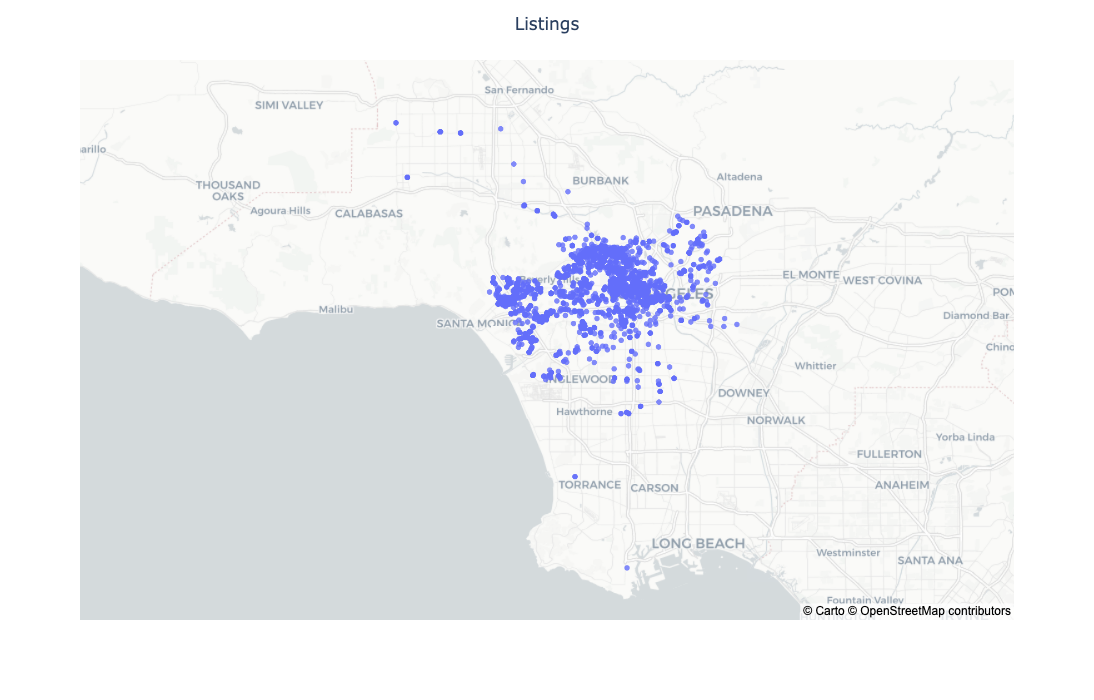

In [239]:
# import libraries
import plotly.express as px
import matplotlib.pyplot as plt


# create scatter map
fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x,
                               mapbox_style="carto-positron",
                               #range_color=range_color,
                               zoom=9,
                               center = {"lat": 34, "lon": -118.4},
                               opacity=.8,

                               )

# options on the layout
fig.update_layout(
        width = 900,
        height = 700,
        title = "Listings",
        title_x = .5
    )
fig.show()